## Erschließungsstrategien für unbekannten Wortschatz von DaF-Lernenden an spanischen Universitäten
# Datenanalyse der Hauptstudie 2018: Inferenzstatisik

##### Werkzeuge und Daten importieren

In [2]:
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import math
from scipy import stats
from biofes import biplot
from sklearn.utils.extmath import randomized_svd
from sklearn.cluster import KMeans, AgglomerativeClustering
#from adjustText import adjust_text
import seaborn as sns
sns.set(style="whitegrid") #"white", "darkgrid"...
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
Daten = pd.read_pickle('D:\Daten\DISS\Daten\Estrategias_Estudiantes_2017-19_ber')

In [4]:
Daten.shape

(401, 377)

In [5]:
#Daten.head(3)

##### Untergruppen und Listen für die Analyse

In [6]:
Daten_A3 = Daten[Daten['A-Q3_27'] >= 1]

In [7]:
Daten_A3.shape

(396, 377)

In [8]:
Finished = Daten[Daten['C-Q1_7'] >= 1]

In [9]:
Finished.shape

(391, 377)

Liste erstellen:

In [10]:
Liste_A_Q2 = [col for col in Daten.columns if 'A-Q2' in col]

In [11]:
Liste_A_Q3 = [col for col in Daten.columns if 'A-Q3' in col]
Liste_A_Q3.pop(3)

'A-Q3_3_TEXT'

In [12]:
Liste_C_Q1 = [col for col in Finished.columns if 'C-Q1' in col]

In [13]:
Liste_D = ['D-Q1','D-Q2','D-Q2a','D-Q2b','D-Q3','D-Q4','D-Q5','D-Q6']

##### Visualisierung

Funktion für Grafiken:

In [14]:
def graf_hist(D,l,sx,sy,nrow,ncol):
    fig = plt.figure(figsize=(sx,sy))
    for i, col in enumerate(l):
        plt.subplot(nrow,ncol,i+1)
        plt.hist(D[col].dropna(),color = '#0063A6')
        plt.xticks([1,2,3,4,5])
        plt.title(col,size=13)
    plt.show()

Funktion für Darstellung der Likert-Skalen...

##### Korrelation

Funktion, um Daten mit bestimmtem Korrelationswert (z.B. über 0,5) zu erhalten:

In [15]:
def get_max_corr(df,col,lim = 0.5):
    return df[(abs(df[col]) > lim) & (df[col].dropna() < 0.99)][col]

### Cronbach's Alpha berechnen

In [16]:
def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    calpha = nitems / float(nitems-1) * (1 - itemvars.sum() / float(tscores.var(ddof=1)))

    return calpha

In [17]:
CronbachAlpha(Daten[Liste_A_Q2])

0.3018915225555093

In [18]:
CronbachAlpha(Daten_A3[Liste_A_Q3])

0.8845773413596196

In [19]:
CronbachAlpha(Finished[Liste_C_Q1])

0.4896684535094027

In [20]:
Liste_A_Q = Liste_A_Q2 + Liste_A_Q3

In [21]:
Liste_AC_Q = Liste_A_Q + Liste_C_Q1

In [22]:
CronbachAlpha(Daten[Liste_AC_Q])

0.918340317521501

### Analyse des Einflusses ausgewählter Variablen auf die Strategiennutzung

Untersuchte Bereiche: 
* A-Q2 (7 Hauptbereiche)
* A-Q3 (31 Einzelstrategien)

Methoden:
* Unterschiedshypothesen: Kruskal-Wallis-Test (Nullhypothese: Es gibt keinen Unterschied zwischen den untersuchten Gruppen in Bezug auf die abhängige Variable.); Levene-Test zur Überprüfung der Vorbedingung ähnlicher Gruppenvarianz
* Zusammenhangshypothesen (Korrelationen): Spearman's Rho (Stärke der Korrelation zwischen Variablen)

Der Kruskal-Wallis-Test kann nur bei gleicher/ähnlicher Gruppenvarianz sinnvoll durchgeführt werden. Um die Annahme ähnlicher Gruppenvarianz zu überprüfen, wird der Levene-Test durchgeführt. Liegt der ermittelte p-Wert über 0,05 kann die Nullhypothese (ähnliche Gruppenvarianz) angenommen werden.

p-value bei Spearman: The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Spearman correlation at least as extreme as the one computed from these datasets. The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.

In [59]:
def df_spearman(data,var,lst,lim = 0.5):
    
    data = data[data[var]!=0]
    
    spearman = []
    for col in lst:
        spearman.append(stats.spearmanr(data[col],data[var]))
    df = pd.DataFrame(spearman)
    
    df_result = df[abs(df['correlation']) > lim]
    df_result.index = [lst[ind] for ind in df_result.index]

    return df_result

In [83]:
def df_mannwhitneyu(data,var,lst,v1,v2):

    data = data[data[var]!=0]

    levene_test = []
    for col in lst:    
        levene_test.append(stats.levene(data[col][data[var]==v1],
                      data[col][data[var]==v2]).pvalue)

    mannwhitneyu_test = []
    for col in lst:    
        mannwhitneyu_test.append(stats.mannwhitneyu(data[col][data[var]==v1],
                      data[col][data[var]==v2]).pvalue)
    
    df = pd.DataFrame(levene_test)
    df.rename(columns={0:'levene'}, inplace=True)
    df['mannwhitneyu'] = mannwhitneyu_test
    
    df_result = df[(df['levene'] > 0.05) & (df['mannwhitneyu'] < 0.05)]
    df_result.index = [lst[ind] for ind in df_result.index]

    return df_result

In [84]:
def df_mannwhitneyu1(data,var,lst,v1,v2):

    levene_test = []
    for col in lst:    
        levene_test.append(stats.levene(data[col][data[var]==v1],
                      data[col][data[var]==v2]).pvalue)

    mannwhitneyu_test = []
    for col in lst:    
        mannwhitneyu_test.append(stats.mannwhitneyu(data[col][data[var]==v1],
                      data[col][data[var]==v2]).pvalue)
    
    df = pd.DataFrame(levene_test)
    df.rename(columns={0:'levene'}, inplace=True)
    df['mannwhitneyu'] = mannwhitneyu_test
    
    df_result = df[(df['levene'] > 0.05) & (df['mannwhitneyu'] < 0.05)]
    df_result.index = [lst[ind] for ind in df_result.index]

    return df_result

In [74]:
def graf_diff(data,item,var):
    
    df = pd.crosstab(data[data[var]!=0][item],data[data[var]!=0][var])
    return df.plot(kind='bar')

##### Studienrichtung

In [78]:
data = Daten[Daten['D-Q2a']!=0]
var = 'D-Q2a'
lst = Liste_A_Q2

levene_test = []
for col in lst:    
    levene_test.append(stats.levene(data[col][data[var]==1],
                        data[col][data[var]==2],
                        data[col][(data[var]==3) | (data[var]==4)],
                        data[col][(data[var]==5) | (data[var]==6) | (data[var]==7) | (data[var]==8)]).pvalue)

kruskal_test = []
for col in lst:    
    kruskal_test.append(stats.kruskal(data[col][data[var]==1],
                        data[col][data[var]==2],
                        data[col][(data[var]==3) | (data[var]==4)],
                        data[col][(data[var]==5) | (data[var]==6) | (data[var]==7) | (data[var]==8)]).pvalue)
    
df = pd.DataFrame(levene_test)
df.rename(columns={0:'levene'}, inplace=True)
df['kruskal-wallis'] = kruskal_test
df_result = df[(df['levene'] > 0.05) & (df['kruskal-wallis'] < 0.05)]

df_result.index = [Liste_A_Q2[ind] for ind in df_result.index]

df_result

,levene,kruskal-wallis
A-Q2_3,0.998252,0.023305
A-Q2_4,0.957940,0.003339
A-Q2_5,0.341038,0.014541
A-Q2_7,0.502690,0.013189


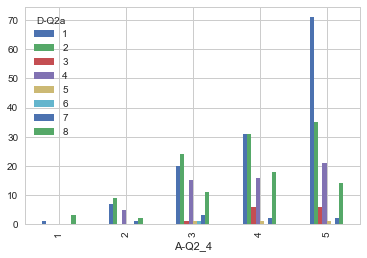

In [75]:
graf_diff(Daten,'A-Q2_4','D-Q2a')

In [42]:
df_spearman(Daten,'D-Q2a',Liste_A_Q2,lim=0.2)

,correlation,pvalue


In [79]:
data = Daten_A3[Daten_A3['D-Q2a']!=0]
var = 'D-Q2a'
lst = Liste_A_Q3

levene_test = []
for col in lst:    
    levene_test.append(stats.levene(data[col][data[var]==1],
                      data[col][data[var]==2],
                      data[col][(data[var]==3) | (data[var]==4)],
                      data[col][data[var]==8]).pvalue)

kruskal_test = []
for col in lst:    
    kruskal_test.append(stats.kruskal(data[col][data[var]==1],
                      data[col][data[var]==2],
                      data[col][(data[var]==3) | (data[var]==4)],
                      data[col][data[var]==8]).pvalue)
    
df = pd.DataFrame(levene_test)
df.rename(columns={0:'levene'}, inplace=True)
df['kruskal-wallis'] = kruskal_test
df_result = df[(df['levene'] > 0.05) & (df['kruskal-wallis'] < 0.05)]

df_result.index = [Liste_A_Q3[ind] for ind in df_result.index]

df_result

,levene,kruskal-wallis
A-Q3_6,0.297875,0.019634
A-Q3_8,0.051162,0.008027
A-Q3_9,0.210758,0.001443
A-Q3_14,0.814902,0.022151
A-Q3_21,0.873457,0.025978
A-Q3_25,0.212701,0.019956
A-Q3_27,0.449675,0.041632


In [67]:
df_spearman(Daten_A3,'D-Q2a',Liste_A_Q3,lim=0.2)

,correlation,pvalue
A-Q3_9,-0.218956,0.000029


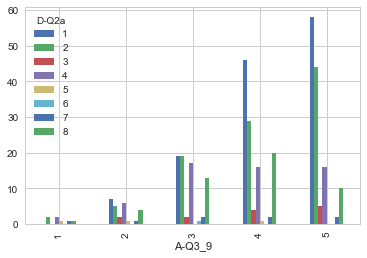

In [68]:
graf_diff(Daten,'A-Q3_9','D-Q2a')

##### Studienjahr

In [80]:
data = Daten[Daten['D-Q2b']!=0]
var = 'D-Q2b'
lst = Liste_A_Q2

levene_test = []
for col in lst:    
    levene_test.append(stats.levene(data[col][data[var]==1],
                      data[col][data[var]==2],
                      data[col][data[var]==3],
                      data[col][data[var]==4]).pvalue)

kruskal_test = []
for col in lst:    
    kruskal_test.append(stats.kruskal(data[col][data[var]==1],
                      data[col][data[var]==2],
                      data[col][data[var]==3],
                      data[col][data[var]==4]).pvalue)
    
df = pd.DataFrame(levene_test)
df.rename(columns={0:'levene'}, inplace=True)
df['kruskal-wallis'] = kruskal_test
df_result = df[(df['levene'] > 0.05) & (df['kruskal-wallis'] < 0.05)]

df_result.index = [Liste_A_Q2[ind] for ind in df_result.index]

df_result

,levene,kruskal-wallis
A-Q2_2,0.916138,0.012699
A-Q2_4,0.097124,0.000738


In [66]:
df_spearman(Daten,'D-Q2b',Liste_A_Q2,lim=0.2)

,correlation,pvalue
A-Q2_3,0.202837,0.000119


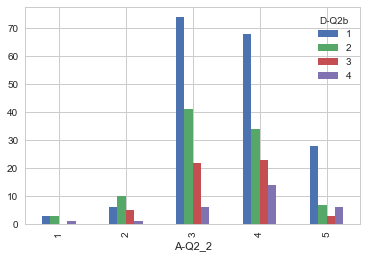

In [70]:
graf_diff(Daten,'A-Q2_2','D-Q2b')

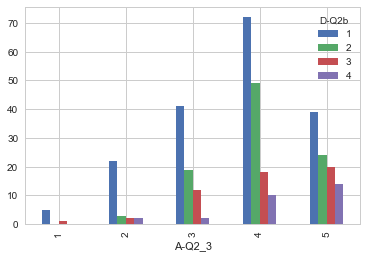

In [76]:
graf_diff(Daten,'A-Q2_3','D-Q2b')

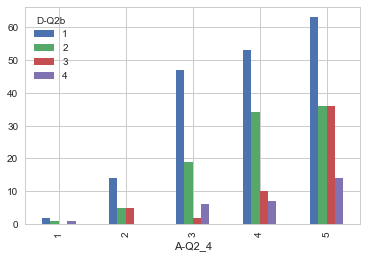

In [71]:
graf_diff(Daten,'A-Q2_4','D-Q2b')

In [85]:
data = Daten_A3[Daten_A3['D-Q2b']!=0]
var = 'D-Q2b'
lst = Liste_A_Q3

levene_test = []
for col in lst:    
    levene_test.append(stats.levene(data[col][data[var]==1],
                      data[col][data[var]==2],
                      data[col][data[var]==3],
                      data[col][data[var]==4]).pvalue)

kruskal_test = []
for col in lst:    
    kruskal_test.append(stats.kruskal(data[col][data[var]==1],
                      data[col][data[var]==2],
                      data[col][data[var]==3],
                      data[col][data[var]==4]).pvalue)
    
df = pd.DataFrame(levene_test)
df.rename(columns={0:'levene'}, inplace=True)
df['kruskal-wallis'] = kruskal_test
df_result = df[(df['levene'] > 0.05) & (df['kruskal-wallis'] < 0.05)]

df_result.index = [Liste_A_Q3[ind] for ind in df_result.index]

df_result

,levene,kruskal-wallis
A-Q3_5,0.775761,0.007446
A-Q3_6,0.149812,0.000054
A-Q3_28,0.108287,0.002512
A-Q3_10,0.879163,0.006836
A-Q3_11,0.416908,0.006570
A-Q3_12,0.629605,0.001299
A-Q3_13,0.448074,0.009360
A-Q3_15,0.811983,0.023202
A-Q3_16,0.185999,0.012465
A-Q3_18,0.774074,0.048192


In [86]:
df_spearman(Daten_A3,'D-Q2b',Liste_A_Q3,lim=0.2)

,correlation,pvalue
A-Q3_6,0.232731,9.401175e-06
A-Q3_7,0.280238,7.898216e-08
A-Q3_8,0.245464,2.863264e-06


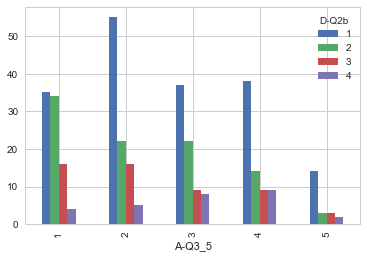

In [87]:
graf_diff(Daten_A3,'A-Q3_5','D-Q2b')

##### Niveau des aktuellen Deutschkurses

In [88]:
data = Daten[Daten['D-Q4']!=0]
var = 'D-Q4'
lst = Liste_A_Q2

levene_test = []
for col in lst:    
    levene_test.append(stats.levene(data[col][data[var]==1],
                                data[col][data[var]==2],
                                data[col][data[var]==3],
                                data[col][data[var]==4],
                                data[col][(data[var]==5) | (data[var]==6)]).pvalue)

kruskal_test = []
for col in lst:    
    kruskal_test.append(stats.kruskal(data[col][data[var]==1],
                                data[col][data[var]==2],
                                data[col][data[var]==3],
                                data[col][data[var]==4],
                                data[col][(data[var]==5) | (data[var]==6)]).pvalue)
    
df = pd.DataFrame(levene_test)
df.rename(columns={0:'levene'}, inplace=True)
df['kruskal-wallis'] = kruskal_test
df_result = df[(df['levene'] > 0.05) & (df['kruskal-wallis'] < 0.05)]

df_result.index = [Liste_A_Q2[ind] for ind in df_result.index]

df_result

,levene,kruskal-wallis
A-Q2_2,0.683827,0.017181
A-Q2_5,0.075343,0.009305
A-Q2_7,0.191650,0.001445


In [89]:
df_spearman(Daten,'D-Q4',Liste_A_Q2,lim=0.2)

,correlation,pvalue
A-Q2_3,0.335502,1.092605e-11
A-Q2_4,0.274630,3.684892e-08


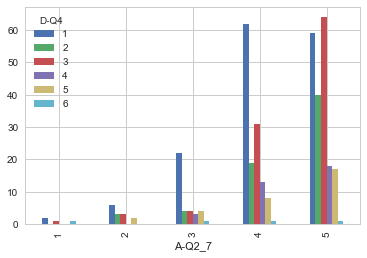

In [92]:
graf_diff(Daten,'A-Q2_7','D-Q4')

In [90]:
data = Daten_A3[Daten_A3['D-Q4']!=0]
var = 'D-Q4'
lst = Liste_A_Q3

levene_test = []
for col in lst:    
    levene_test.append(stats.levene(data[col][data[var]==1],
                                data[col][data[var]==2],
                                data[col][data[var]==3],
                                data[col][data[var]==4],
                                data[col][(data[var]==5) | (data[var]==6)]).pvalue)

kruskal_test = []
for col in lst:    
    kruskal_test.append(stats.kruskal(data[col][data[var]==1],
                                data[col][data[var]==2],
                                data[col][data[var]==3],
                                data[col][data[var]==4],
                                data[col][(data[var]==5) | (data[var]==6)]).pvalue)
    
df = pd.DataFrame(levene_test)
df.rename(columns={0:'levene'}, inplace=True)
df['kruskal-wallis'] = kruskal_test
df_result = df[(df['levene'] > 0.05) & (df['kruskal-wallis'] < 0.05)]

df_result.index = [Liste_A_Q3[ind] for ind in df_result.index]

df_result

,levene,kruskal-wallis
A-Q3_1,0.657177,0.012095
A-Q3_2,0.992696,0.017022
A-Q3_3,0.458299,0.001948
A-Q3_5,0.282900,0.003671
A-Q3_28,0.459591,0.001701
A-Q3_10,0.777149,0.000159
A-Q3_11,0.191623,0.000066
A-Q3_12,0.455224,0.000458
A-Q3_13,0.972389,0.000577
A-Q3_29,0.476372,0.014806


In [91]:
df_spearman(Daten_A3,'D-Q4',Liste_A_Q3,lim=0.2)

,correlation,pvalue
A-Q3_6,0.330875,2.166161e-11
A-Q3_7,0.402696,1.344218e-16
A-Q3_8,0.405284,8.237774e-17
A-Q3_9,0.242192,1.341143e-06
A-Q3_10,0.222034,9.851938e-06
A-Q3_11,0.218990,1.310933e-05
A-Q3_14,0.236544,2.387911e-06
A-Q3_16,0.205321,4.502119e-05


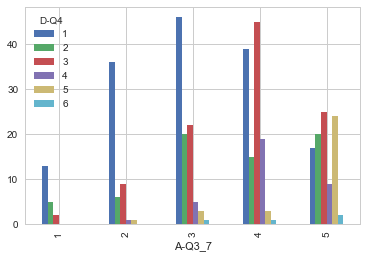

In [93]:
graf_diff(Daten_A3,'A-Q3_7','D-Q4')

##### Sprachkenntnisse

##### Alter

##### Geschlecht

In [94]:
df_mannwhitneyu(Daten,'D-Q6',Liste_A_Q2,1,2)

,levene,mannwhitneyu
A-Q2_2,0.210307,0.002952
A-Q2_6,0.949190,0.007064


In [95]:
df_spearman(Daten,'D-Q6',Liste_A_Q2,lim=0.1)

,correlation,pvalue
A-Q2_2,0.146489,0.004018
A-Q2_6,-0.124599,0.014558


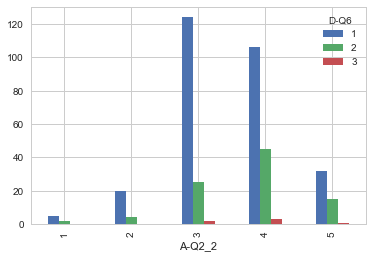

In [100]:
graf_diff(Daten,'A-Q2_2','D-Q6')

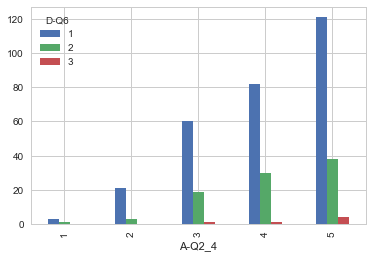

In [101]:
graf_diff(Daten,'A-Q2_4','D-Q6')

In [96]:
df_mannwhitneyu(Daten_A3,'D-Q6',Liste_A_Q3,1,2)

,levene,mannwhitneyu
A-Q3_4,0.842056,0.015904
A-Q3_15,0.498840,0.001925
A-Q3_16,0.905823,0.042665
A-Q3_19,0.662626,0.021854
A-Q3_20,0.538395,0.026829


In [97]:
df_spearman(Daten_A3,'D-Q6',Liste_A_Q3,lim=0.1)

,correlation,pvalue
A-Q3_15,-0.100958,0.048044
A-Q3_19,0.116416,0.022513
A-Q3_20,0.106364,0.037212


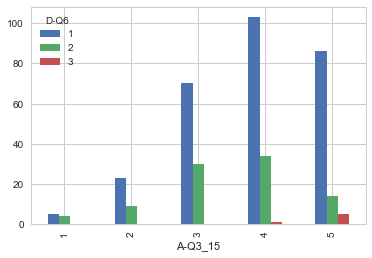

In [103]:
graf_diff(Daten_A3,'A-Q3_15','D-Q6')

##### Strategienerwerbskontexte

##### Erhebungssituation

In [104]:
df_mannwhitneyu1(Finished,'D-Q9_1',Liste_A_Q2,1,0)

,levene,mannwhitneyu
A-Q2_1,0.125453,0.001112
A-Q2_2,0.075275,0.023618
A-Q2_4,0.176190,0.017193


In [105]:
df_mannwhitneyu1(Finished,'D-Q9_1',Liste_A_Q3,1,0)

,levene,mannwhitneyu
A-Q3_4,0.764250,0.024005
A-Q3_16,0.221273,0.004463
A-Q3_20,0.284533,0.007207


Nur bei wenigen Items kann ein Einfluss der Erhebungssituation vermutet werden. Die Ergebnisse sind nicht eindeutig, zudem kann der Einfluss auch durch die Erhebung an unterschiedlichen Universitäten zustandekommen. 

In [106]:
data = Daten_A3[Daten_A3['D-Q1']!=0]
var = 'D-Q1'
lst = Liste_A_Q3

levene_test = []
for col in lst:    
    levene_test.append(stats.levene(data[col][data[var]==67],
                      data[col][data[var]!=67]).pvalue)

mannwhitneyu_test = []
for col in lst:    
    mannwhitneyu_test.append(stats.mannwhitneyu(data[col][data[var]==67],
                      data[col][data[var]!=67]).pvalue)
    
df = pd.DataFrame(levene_test)
df.rename(columns={0:'levene'}, inplace=True)
df['mannwhitneyu'] = mannwhitneyu_test
df_result = df[(df['levene'] > 0.05) & (df['mannwhitneyu'] < 0.05)]

df_result.index = [Liste_A_Q3[ind] for ind in df_result.index]

df_result

,levene,mannwhitneyu
A-Q3_6,0.150175,0.001501
A-Q3_7,0.058677,0.003824
A-Q3_9,0.078521,0.001246
A-Q3_10,0.581073,0.016558
A-Q3_14,0.371790,0.005926
A-Q3_22,0.210664,0.046006
A-Q3_30,0.650128,0.001243
A-Q3_31,0.612692,0.028933


In [107]:
data = Daten_A3[Daten_A3['D-Q1']!=0]
var = 'D-Q1'
lst = Liste_A_Q3

levene_test = []
for col in lst:    
    levene_test.append(stats.levene(data[col][data[var]==73],
                      data[col][data[var]!=73]).pvalue)

mannwhitneyu_test = []
for col in lst:    
    mannwhitneyu_test.append(stats.mannwhitneyu(data[col][data[var]==73],
                      data[col][data[var]!=73]).pvalue)
    
df = pd.DataFrame(levene_test)
df.rename(columns={0:'levene'}, inplace=True)
df['mannwhitneyu'] = mannwhitneyu_test
df_result = df[(df['levene'] > 0.05) & (df['mannwhitneyu'] < 0.05)]

df_result.index = [Liste_A_Q3[ind] for ind in df_result.index]

df_result

,levene,mannwhitneyu
A-Q3_7,0.144175,2.314762e-05
A-Q3_8,0.718405,1.180272e-07
A-Q3_9,0.173893,8.154005e-07
A-Q3_28,0.640476,1.907866e-02
A-Q3_11,0.762787,1.512100e-03
A-Q3_12,0.524256,9.926228e-03
A-Q3_29,0.994299,1.383163e-04
A-Q3_14,0.854219,8.102062e-07
A-Q3_15,0.276254,2.416914e-04
A-Q3_16,0.341220,1.808607e-02


Eine weitere besondere Erhebungssituation stellt die Durchführung der Befragung mittels der Papierversion des Fragebogens dar. Die größte Gruppe von Studierenden, die mittels Papierfragebogen befragt wurden, stellt jene der Universität Sevilla (n=56) dar. Im Vergleich der Gruppe aus Sevilla mit den Studierenden anderer Universitäten zeigen sich tatsächlich einige Unterschiede im Antwortverhalten. 

Ein ähnliches Bild zeigt sich jedoch auch, wenn die Analyse mit anderen Universitäten (z.B. Vigo oder Salamanca) durchgeführt wird. 

Ein Einfluss der Verwendung des Papierfragebogens auf das Antwortverhalten kann daher nicht mit Sicherheit festgestellt werden. 

In [108]:
data = Daten_A3[Daten_A3['D-Q1']!=0]
var = 'D-Q1'
lst = Liste_A_Q3

levene_test = []
for col in lst:    
    levene_test.append(stats.levene(data[col][data[var]==63],
                                data[col][data[var]==67],
                                data[col][data[var]==73],
                                data[col][data[var]==29],
                                data[col][data[var]==66],
                                data[col][data[var]==20]).pvalue)

kruskal_test = []
for col in lst:    
    kruskal_test.append(stats.kruskal(data[col][data[var]==63],
                                data[col][data[var]==67],
                                data[col][data[var]==73],
                                data[col][data[var]==29],
                                data[col][data[var]==66],
                                data[col][data[var]==20]).pvalue)
    
df = pd.DataFrame(levene_test)
df.rename(columns={0:'levene'}, inplace=True)
df['kruskal-wallis'] = kruskal_test
df_result = df[(df['levene'] > 0.05) & (df['kruskal-wallis'] < 0.05)]

df_result.index = [Liste_A_Q3[ind] for ind in df_result.index]

df_result

,levene,kruskal-wallis
A-Q3_4,0.203158,0.024439
A-Q3_7,0.074231,0.000055
A-Q3_29,0.811059,0.004608
A-Q3_14,0.490878,0.000005
A-Q3_15,0.565071,0.000925
A-Q3_16,0.363125,0.004294
A-Q3_17,0.974641,0.005994
A-Q3_18,0.223950,0.038368
A-Q3_19,0.836926,0.045812
A-Q3_21,0.121267,0.040794


Die Analyse zeigt, dass ein Zusammenhang zwischen bestimmten Items und der Zugehörigkeit der Befragten zu unterschiedlichen Universitäten vorliegt. Allerdings sind mit der Universitätszugehörigkeit auch andere Faktoren wie Studienrichtung und Niveau des besuchten Deutschkurses sowie die Lehrkraft (nicht als Faktor erhoben, aber in der Fachliteratur angenommen) verbunden, sodass keine aussagekräftigen Schlüsse gezogen werden können. 

##### Pilotstudie

In der Folge wird untersucht, ob sich das Antwortverhalten der TN an der Pilotstudie und der Hauptstudie an der Universität Salamanca unterscheidet.

In [217]:
Finished[Finished['D-Q1']==63]['pilot'].value_counts()

0    88
1    65
Name: pilot, dtype: int64

In [109]:
df_mannwhitneyu1(Daten[Daten['D-Q1']==63],'pilot',Liste_A_Q2,1,0)

,levene,mannwhitneyu
A-Q2_3,0.342233,0.007910
A-Q2_4,0.743922,0.027246


In [110]:
df_mannwhitneyu1(Daten_A3[Daten_A3['D-Q1']==63],'pilot',Liste_A_Q3,1,0)

,levene,mannwhitneyu
A-Q3_6,0.074754,0.000359
A-Q3_7,0.926998,0.000009
A-Q3_8,0.187602,0.000089
A-Q3_9,0.523529,0.000646
A-Q3_28,0.380871,0.041719
A-Q3_10,0.175957,0.002852
A-Q3_11,0.145783,0.040142
A-Q3_16,0.086322,0.002777
A-Q3_20,0.512985,0.009496
A-Q3_27,0.878241,0.041842


Tatsächlich gibt es Hinweise auf unterschiedliches Antwortverhalten. Dieses kann jedoch durch andere Variablen, die ebenfalls beide Stichproben unterscheiden, zustandegekommen sein.

In [111]:
df_mannwhitneyu1(Finished[Finished['D-Q1']==63],'pilot',Liste_D[1:],1,0)

,levene,mannwhitneyu
D-Q2,0.670995,0.040099
D-Q3,0.292877,0.000013
D-Q5,0.702863,0.015771


Als zusätzlicher Test wurden die zuvor dargestellten Analysen auch unter Ausschluss der Teilnehmer der Pilotstudie durchgeführt. Die Ergebnisse unterscheiden sich nicht wesentlich, zum Teil wären weniger Unterschiede zwischen Gruppen (z.B. Studienrichtungen) erkenntlich. Dies lässt vermuten, dass die unterschiedliche Zusammensetzung der Stichprobe mehr Einfluss auf das Antwortverhalten hat als die Verwendung eines geringfügig anders gestalteten Fragebogens. (Die sprachlich abgeänderten Items 12 und 14 zeigen kein verändertes Antwortverhalten.)

#### A-Q3 (31 Einzelstrategien)

##### Gruppierung der Strategien nach Kategorien:

In [129]:
strat = {'S1': ['A-Q3_5','A-Q3_6','A-Q3_7','A-Q3_8','A-Q3_9'], 
         'S2': ['A-Q3_1','A-Q3_2','A-Q3_3','A-Q3_4','A-Q3_5'],
         'S3': ['A-Q3_9','A-Q3_10','A-Q3_11','A-Q3_12'],
         'S4': ['A-Q3_13','A-Q3_14','A-Q3_15','A-Q3_16','A-Q3_17','A-Q3_18','A-Q3_19','A-Q3_20'],
         'S4a': ['A-Q3_13','A-Q3_14','A-Q3_15','A-Q3_16'],
         'S4b': ['A-Q3_17','A-Q3_18','A-Q3_19','A-Q3_20'],
         'S5': ['A-Q3_21','A-Q3_22','A-Q3_23','A-Q3_24','A-Q3_25'],
         'S6': ['A-Q3_26','A-Q3_27','A-Q3_28','A-Q3_29','A-Q3_30','A-Q3_31']}

* S1: Auf Wortebene - intralingual
* S2: Auf Wortebene - interlingual
* S3: Auf Satz- und Textebene - engerer Kontext
* S4: Auf Satz- und Textebene - weiterer Kontext (S4a: intratextuell, S4b: Bezug zu Fach- und Weltwissen)
* S5: Außersprachlicher Kontext
* S6: Metakognitive Strategien

In [130]:
levene_test = []
for col in Liste_A_Q3:    
    levene_test.append(stats.levene(Daten[Daten['D-Q4']!=0][col][Daten[Daten['D-Q4']!=0]['D-Q4']==1],
                      Daten[Daten['D-Q4']!=0][col][Daten[Daten['D-Q4']!=0]['D-Q4']==2],
                      Daten[Daten['D-Q4']!=0][col][Daten[Daten['D-Q4']!=0]['D-Q4']==3],
                      Daten[Daten['D-Q4']!=0][col][Daten[Daten['D-Q4']!=0]['D-Q4']==4]).pvalue)

kruskal_test = []
for col in Liste_A_Q3:    
    kruskal_test.append(stats.kruskal(Daten[Daten['D-Q4']!=0][col][Daten[Daten['D-Q4']!=0]['D-Q4']==1],
                      Daten[Daten['D-Q4']!=0][col][Daten[Daten['D-Q4']!=0]['D-Q4']==2],
                      Daten[Daten['D-Q4']!=0][col][Daten[Daten['D-Q4']!=0]['D-Q4']==3],
                      Daten[Daten['D-Q4']!=0][col][Daten[Daten['D-Q4']!=0]['D-Q4']==4]).pvalue)
    

df = pd.DataFrame(levene_test)
df.rename(columns={0:'levene'}, inplace=True)
df['kruskal'] = kruskal_test
df

,levene,kruskal
0,0.555363,1.573900e-02
1,0.968915,7.646229e-03
2,0.740011,6.485630e-04
3,0.008212,3.454320e-03
4,0.177997,1.375723e-01
5,0.000450,2.204289e-06
6,0.000491,3.795226e-08
7,0.001029,3.702929e-11
8,0.085962,1.120234e-03
9,0.392046,1.251121e-02


#### B-Q1 (Kontexte des Strategienerwerbs)

In [131]:
Kontexte = Finished[['B-Q1_1','B-Q1_2','B-Q1_3','B-Q1_4','B-Q1_5','B-Q1_6','B-Q1_7','B-Q1_8','B-Q1_9','B-Q1_10','B-Q1_11']]

In [132]:
DF_Kontexte = Kontexte.apply(pd.value_counts).fillna(0).astype(integer)

* 1- En las clases de Lengua y Literatura en el colegio o instituto
* 2- En las clases de inglés en el colegio o instituto
* 3- En otras clases de idiomas en el colegio o instituto
* 4- En clases de alemán anteriores en la Universidad
* 5- En otras asignaturas de mi carrera universitaria
* 6- En clases de lenguas en escuelas de idiomas o academias
* 7- En mi curso de alemán actual
* 8- En mi familia, con mis amigos/as o compañeros/as de clase
* 9- Por mi cuenta, sin ayuda de otras personas
* 10- Otros:
* 11- No sé cómo he aprendido estas estrategias.

#### B-Q2 (Methoden des Strategienerwerbs)

Erwerbskontexte:

In [133]:
erwerb = {'E1': ['B-Q2-1_1','B-Q2-1_2','B-Q2-1_3','B-Q2-1_4','B-Q2-1_5','B-Q2-1_6','B-Q2-1_7'], 
         'E2': ['B-Q2-2_1','B-Q2-2_2','B-Q2-2_3','B-Q2-2_4','B-Q2-2_5','B-Q2-2_6','B-Q2-2_7'],
         'E3': ['B-Q2-3_1','B-Q2-3_2','B-Q2-3_3','B-Q2-3_4','B-Q2-3_5','B-Q2-3_6','B-Q2-3_7'],
         'E4': ['B-Q2-4_1','B-Q2-4_2','B-Q2-4_3','B-Q2-4_4','B-Q2-4_5','B-Q2-4_6','B-Q2-4_7'],
         'E5': ['B-Q2-5_1','B-Q2-5_2','B-Q2-5_3','B-Q2-5_4','B-Q2-5_5','B-Q2-5_6','B-Q2-5_7'],
         'E6': ['B-Q2-6_1','B-Q2-6_2','B-Q2-6_3','B-Q2-6_4','B-Q2-6_5','B-Q2-6_6','B-Q2-6_7'],
         'E7': ['B-Q2-7_1','B-Q2-7_2','B-Q2-7_3','B-Q2-7_4','B-Q2-7_5','B-Q2-7_6','B-Q2-7_7'],
         'E8': ['B-Q2-8_1','B-Q2-8_2','B-Q2-8_3','B-Q2-8_4','B-Q2-8_5'],
         'E9': ['B-Q2-9_1','B-Q2-9_2','B-Q2-9_3','B-Q2-9_4','B-Q2-9_5']}

Methoden des Stragienerwerbs (kontextübergreifend in Unterrichtssituationen):

In [134]:
erwerb1 = {'U1': ['B-Q2-1_1','B-Q2-2_1','B-Q2-3_1','B-Q2-4_1','B-Q2-5_1','B-Q2-6_1','B-Q2-7_1'], 
         'U2': ['B-Q2-1_2','B-Q2-2_2','B-Q2-3_2','B-Q2-4_2','B-Q2-5_2','B-Q2-6_2','B-Q2-7_2'],
         'U3': ['B-Q2-1_3','B-Q2-2_3','B-Q2-3_3','B-Q2-4_3','B-Q2-5_3','B-Q2-6_3','B-Q2-7_3'],
         'U4': ['B-Q2-1_4','B-Q2-2_4','B-Q2-3_4','B-Q2-4_4','B-Q2-5_4','B-Q2-6_4','B-Q2-7_4'],
         'U5': ['B-Q2-1_5','B-Q2-2_5','B-Q2-3_5','B-Q2-4_5','B-Q2-5_5','B-Q2-6_5','B-Q2-7_5'],
         'U6': ['B-Q2-1_6','B-Q2-2_6','B-Q2-3_6','B-Q2-4_6','B-Q2-5_6','B-Q2-6_6','B-Q2-7_6'],
         'U7': ['B-Q2-1_7','B-Q2-2_7','B-Q2-3_7','B-Q2-4_7','B-Q2-5_7','B-Q2-6_7','B-Q2-7_7']}

Auswahl der TN, die mindestens einmal eine bestimmte Methode angegeben haben:

In [135]:
Stud_U1 = Finished[(Finished['B-Q2-1_1'] == 1) | (Finished['B-Q2-2_1'] == 1) | (Finished['B-Q2-3_1'] == 1) | (Finished['B-Q2-4_1'] == 1 | (Finished['B-Q2-5_1'] == 1 | (Finished['B-Q2-6_1'] == 1) | (Finished['B-Q2-7_1'] == 1)))]
Stud_U2 = Finished[(Finished['B-Q2-1_2'] == 1) | (Finished['B-Q2-2_2'] == 1) | (Finished['B-Q2-3_2'] == 1) | (Finished['B-Q2-4_2'] == 1 | (Finished['B-Q2-5_2'] == 1 | (Finished['B-Q2-6_2'] == 1) | (Finished['B-Q2-7_2'] == 1)))]
Stud_U3 = Finished[(Finished['B-Q2-1_3'] == 1) | (Finished['B-Q2-2_3'] == 1) | (Finished['B-Q2-3_3'] == 1) | (Finished['B-Q2-4_3'] == 1 | (Finished['B-Q2-5_3'] == 1 | (Finished['B-Q2-6_3'] == 1) | (Finished['B-Q2-7_3'] == 1)))]
Stud_U4 = Finished[(Finished['B-Q2-1_4'] == 1) | (Finished['B-Q2-2_4'] == 1) | (Finished['B-Q2-3_4'] == 1) | (Finished['B-Q2-4_4'] == 1 | (Finished['B-Q2-5_4'] == 1 | (Finished['B-Q2-6_4'] == 1) | (Finished['B-Q2-7_4'] == 1)))]
Stud_U5 = Finished[(Finished['B-Q2-1_5'] == 1) | (Finished['B-Q2-2_5'] == 1) | (Finished['B-Q2-3_5'] == 1) | (Finished['B-Q2-4_5'] == 1 | (Finished['B-Q2-5_5'] == 1 | (Finished['B-Q2-6_5'] == 1) | (Finished['B-Q2-7_5'] == 1)))]
Stud_U6 = Finished[(Finished['B-Q2-1_6'] == 1) | (Finished['B-Q2-2_6'] == 1) | (Finished['B-Q2-3_6'] == 1) | (Finished['B-Q2-4_6'] == 1 | (Finished['B-Q2-5_6'] == 1 | (Finished['B-Q2-6_6'] == 1) | (Finished['B-Q2-7_6'] == 1)))]

In [136]:
Stud_U = []
Stud_U.append(Stud_U1.shape[0])
Stud_U.append(Stud_U2.shape[0])
Stud_U.append(Stud_U3.shape[0])
Stud_U.append(Stud_U4.shape[0])
Stud_U.append(Stud_U5.shape[0])
Stud_U.append(Stud_U6.shape[0])

In [137]:
Stud_U = pd.Series(Stud_U)
Stud_U.index += 1

In [138]:
Stud_E8 = Finished[(Finished['B-Q2-8_1'] == 1) | (Finished['B-Q2-8_2'] == 1) | (Finished['B-Q2-8_3'] == 1) | (Finished['B-Q2-8_4'] == 1 | (Finished['B-Q2-8_5'] == 1))]
Stud_E9 = Finished[(Finished['B-Q2-9_1'] == 1) | (Finished['B-Q2-9_2'] == 1) | (Finished['B-Q2-9_3'] == 1) | (Finished['B-Q2-9_4'] == 1 | (Finished['B-Q2-9_5'] == 1))]

##### Methoden des Strategienerwerbs nach Erwerbskontexten

* (1)	Las estrategias se presentaron (y explicaron) en clase.
* (2)	El/La profesor/a dio consejos sobre cómo familiarizarse de manera autónoma con estas estrategias, p. ej. mediante páginas web, libros u otros materiales que explican estrategias de aprendizaje. 
* (3)	Estas estrategias se explicaron y practicaron con ejemplos concretos, realizando tareas, p. ej. leyendo un texto difícil.
* (4)	Se probaron y se compararon diferentes estrategias.
* (5)	Se reflexionó sobre el uso de estas estrategias, p. ej. sobre qué estrategia sería adecuada en una situación y/o para una persona determinada.
* (6)	Durante las clases he aprendido estas estrategias de manera inconsciente, p. ej. mientras leía textos difíciles, sin explicación o indicación del/de la profesor/a.
* (7)	Otros:

In [139]:
DF_Erwerb = pd.DataFrame(np.nan, columns=list(erwerb.keys())[:7], index = [1,2,3,4,5,6,7])

In [140]:
for key in list(erwerb.keys())[:7]:
    DF_Erwerb[key] = Finished[erwerb[key]].sum().values

* (1)	He conocido estas estrategias en mi familia.
* (2)	He conocido estas estrategias hablando con amigos/as y conocidos/as.
* (3)	He conocido estas estrategias hablando con compañeros/as de clase.
* (4)	He conocido estas estrategias imitando hábitos de trabajo de compañeros/as de clase aventajados/as.
* (5)	Otros:

* (1)	He desarrollado estas estrategias por mi cuenta durante el aprendizaje y el uso de idiomas, p. ej. leyendo textos difíciles.
* (2)	He probado diferentes cosas y me he dado cuenta de qué funciona mejor para mi.
* (3)	He aprendido estas estrategias con ayuda de páginas web o blogs.
* (4)	He aprendido estas estrategias con ayuda de libros.
* (5)	He aprendido estas estrategias con ayuda de otros materiales. (Opcional: Cuáles?)

##### Übersicht über Methoden des Strategienerwerbs in Unterrichtskontexten

In [141]:
Erwerb_U = []
for lst in erwerb1:
        Erwerb_U.append(Finished[erwerb1[lst]].apply(pd.value_counts).astype(integer).iloc[1].sum())

In [142]:
Erwerb_U

[480, 630, 491, 220, 295, 728, 44]

In [143]:
Erwerb_U = pd.Series(Erwerb_U)

In [144]:
Erwerb_U.index += 1

#### C-Q1

1
Pienso que en alemán utilizo estas estrategias con éxito. 

2
Estas estrategias son un tema importante en mis clases de alemán.

3
Utilizo estas estrategias a menudo fuera del aula, p. ej. cuando leo textos en alemán en mi tiempo libre.

4
Estas estrategias son útiles para ampliar el vocabulario en alemán.

5
Estas estrategias son útiles para entender mejor textos en alemán.

6
Estas estrategias deberían explicarse y practicarse en las clases de alemán.

7
No hace falta aprender estas estrategias, ya que las usamos en cualquier caso de forma inconsciente. 


### Biplot?

In [145]:
def vector_to_shape(v):
    markers = ["," , "o" , "v" , "^", "x", "D", "*", "1", "p"]
    return [markers[el] for el in v]

In [146]:
def vector_to_color(v):
    col = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'saddlebrown','orange']
    return [col[el] for el in v]

In [147]:
def graf_biplot(data, dim, vcol, dim1 = 0, dim2 = 1, sx = 10, sy = 10):
    
    B = biplot.Classic(data, dim, method = 1) 
    R = B.RowCoord
    C = B.ColCoord
    
    fig = plt.figure(figsize=(sx,sy))
    ax = fig.add_subplot(111)
    
    color_v = vector_to_color(vcol)
    sh_v = vector_to_shape(vcol)
    
    for i in range(C.shape[0]):
        ax.arrow(0,0,C[i,dim1],C[i,dim2], alpha = 0.7)
        #ax.scatter(C[i,dim1],C[i,dim2]) # Hier würden Linien nicht angezeigt.
        ax.text(C[i,dim1],C[i,dim2],data.columns[i],fontsize=15, alpha = 0.7)

    for i in range(R.shape[0]):
        ax.scatter(R[i,dim1],R[i,dim2], s = 20, c = color_v[i], marker = sh_v[i])
    
    ax.legend(vcol.unique());

In [148]:
def graf_cplot(data, dim, nclust, dim1 = 0, dim2 = 1, sx = 10, sy = 10):
    
    B = biplot.Classic(data, dim, method = 1) 
    R = B.RowCoord
    C = B.ColCoord
    
    ward = AgglomerativeClustering(n_clusters=nclust).fit(data)
    
    fig = plt.figure(figsize=(sx,sy))
    ax = fig.add_subplot(111)

    sh_v = vector_to_shape(ward.labels_)
    color_v = vector_to_color(ward.labels_)

    for i in range(C.shape[0]):
        ax.arrow(0,0,C[i,dim1],C[i,dim2], alpha = 0.7)
        #ax.scatter(C[i,dim1],C[i,dim2]) # Hier würden Linien nicht angezeigt.
        ax.text(C[i,dim1],C[i,dim2],data.columns[i],fontsize=15, alpha = 0.7)

    for i in range(R.shape[0]):
        ax.scatter(R[i,dim1],R[i,dim2], s = 20, c = color_v[i] , marker = sh_v[i]);

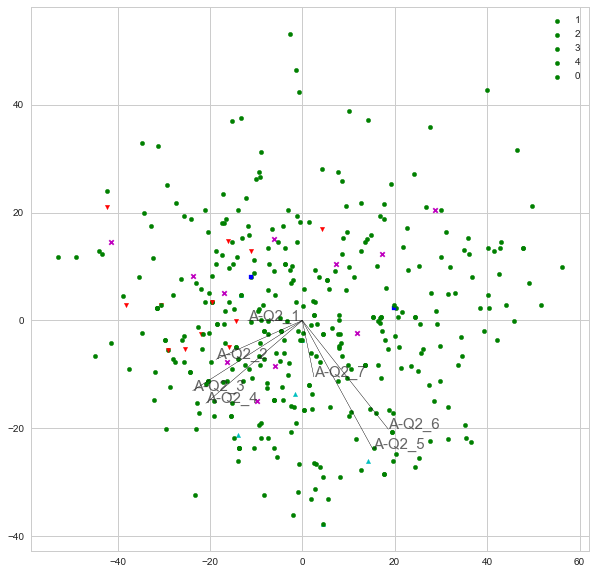

In [164]:
graf_biplot(Finished[Liste_A_Q2],7,Finished['D-Q2'])

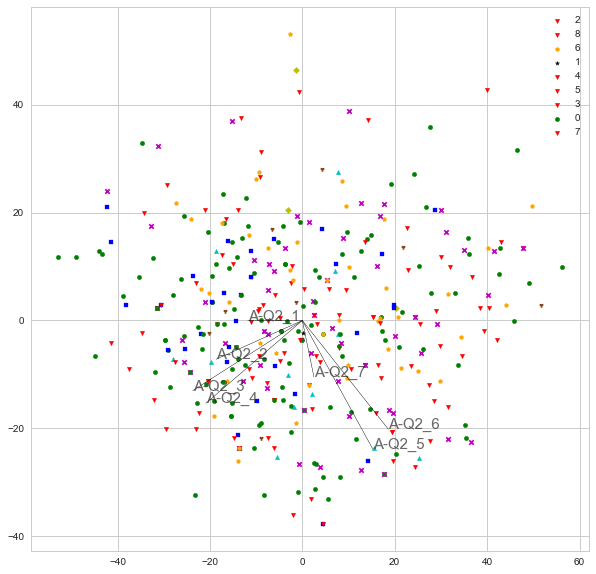

In [150]:
graf_biplot(Finished[Liste_A_Q2],7,Finished['D-Q2a'])

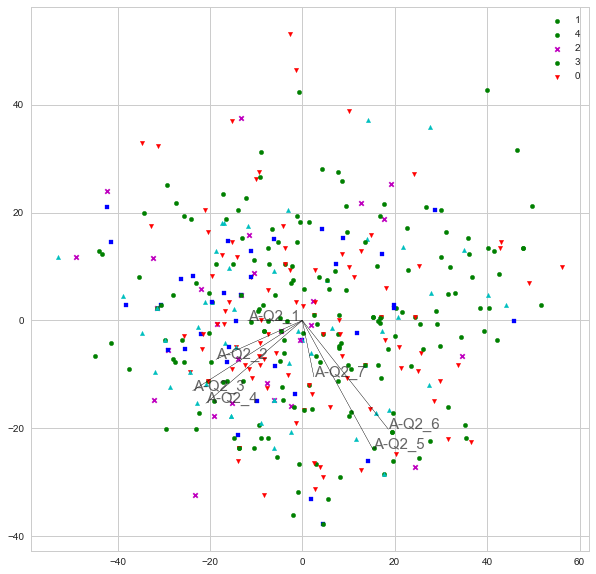

In [151]:
graf_biplot(Finished[Liste_A_Q2],7,Finished['D-Q2b'])

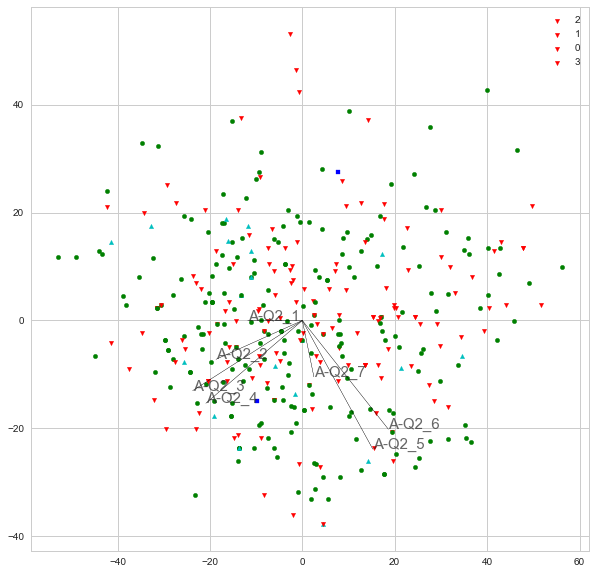

In [152]:
graf_biplot(Finished[Liste_A_Q2],7,Finished['D-Q3'])

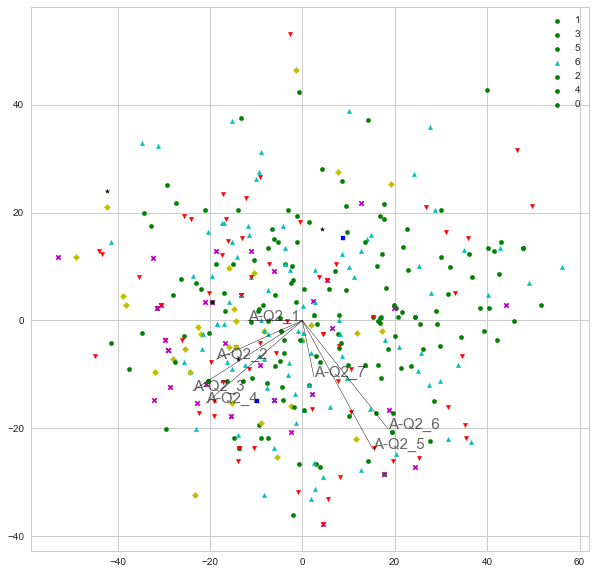

In [153]:
graf_biplot(Finished[Liste_A_Q2],7,Finished['D-Q4'])

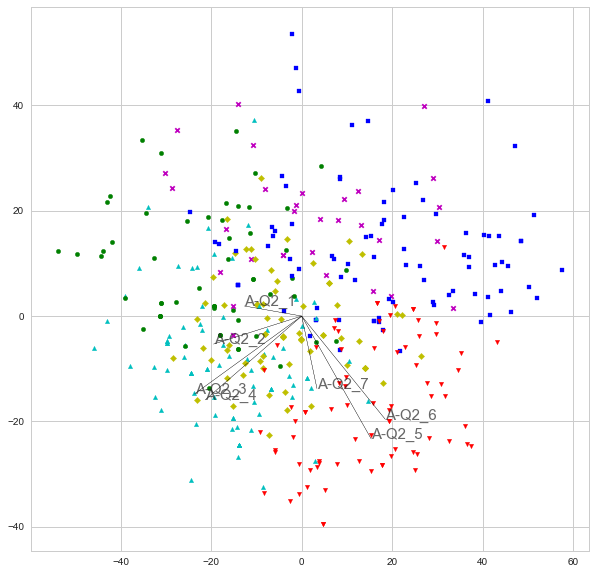

In [154]:
graf_cplot(Daten[Liste_A_Q2],7,6)

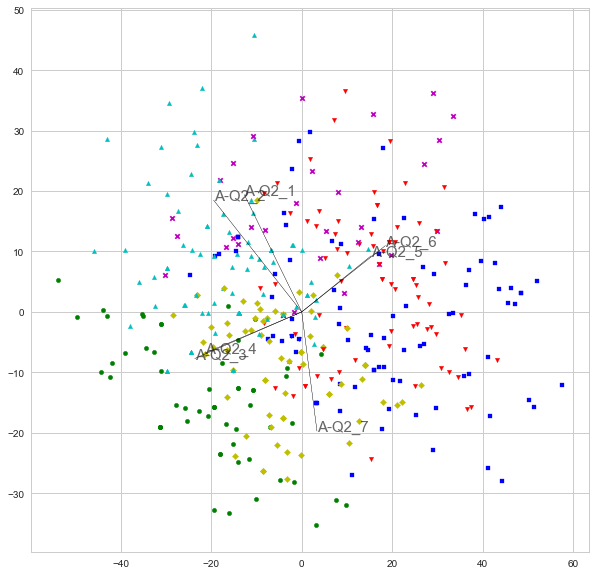

In [155]:
graf_cplot(Daten[Liste_A_Q2],7,6,dim1=0,dim2=2)

In [156]:
fakt = {'F1': ['A-Q3_6','A-Q3_7','A-Q3_8','A-Q3_9','A-Q3_14','A-Q3_15','A-Q3_10'], 
        'F2': ['A-Q3_1','A-Q3_2','A-Q3_3','A-Q3_4','A-Q3_5'],
        'F3': ['A-Q3_10','A-Q3_11','A-Q3_12','A-Q3_13'],
        'F4': ['A-Q3_16','A-Q3_17','A-Q3_18','A-Q3_19'],
        'F5': ['A-Q3_21','A-Q3_22','A-Q3_23','A-Q3_24'],
        'F6': ['A-Q3_26','A-Q3_27','A-Q3_30','A-Q3_31'],
        'F7': ['A-Q3_20','A-Q3_28','A-Q3_29']}

Ergebnisse der Faktorenanalyse (mit R durchgeführt)

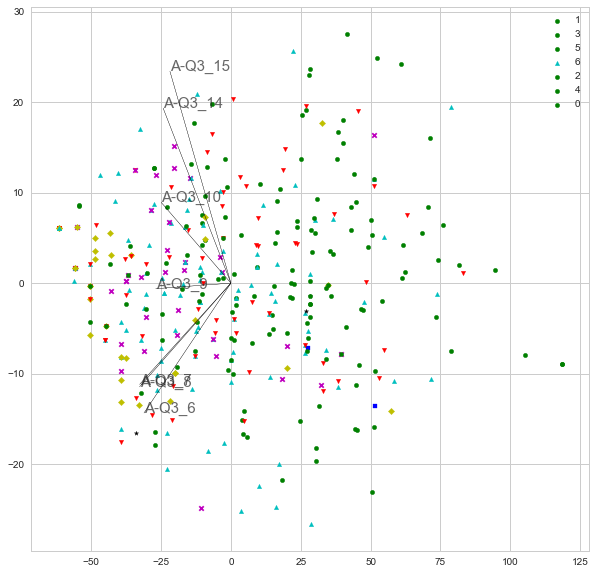

In [157]:
graf_biplot(Finished[fakt['F1']],7,Finished['D-Q4'])

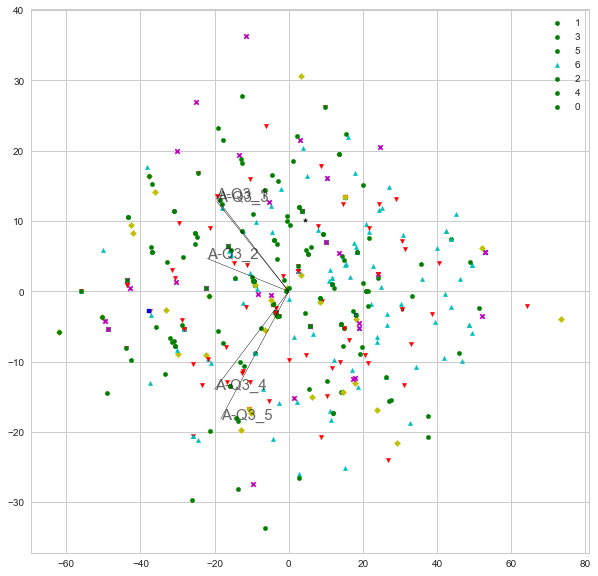

In [158]:
graf_biplot(Finished[fakt['F2']],5,Finished['D-Q4'])

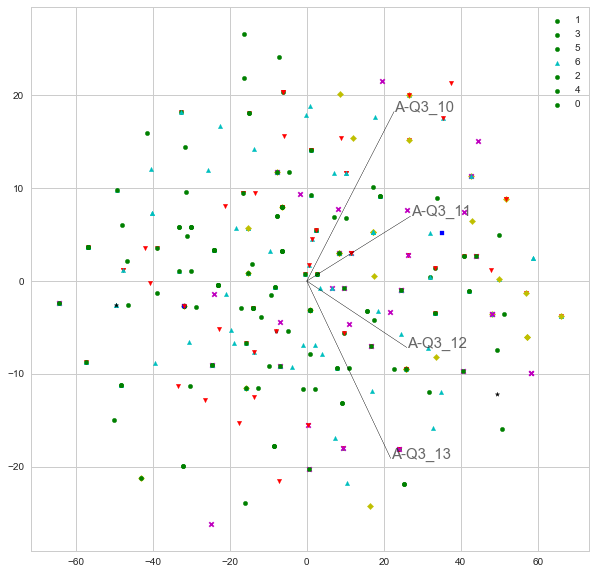

In [159]:
graf_biplot(Finished[fakt['F3']],4,Finished['D-Q4'])